In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from graph_toolset import coreness, degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import pickle

%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    return res

In [3]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [4]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [5]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)
    plt.show()

In [6]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [34]:
def plot_2d(alphas, bs, filenames, last, keys, names, add_tiks=False):
    fig, grid = plt.subplots(nrows=len(names), ncols=len(keys), figsize=(3 * len(keys), 2.5 * len(names)), sharex=True, sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    cur_letter = 0
    LIMS_BY_KEY = {'rho': (0., 1.), 'stdrho': (0., .01), 'l': (0, .8)}
    TIKS_BY_KEY = {'rho': [.1, .5, .9],
                  'stdrho': [.001, .005, .009],
                  'l': [.1, .3, .5, .7]}
    LVLS_BY_KEY = {'rho': [.5, .7, .9],
                  'stdrho': [.03],
                  'l': []}
    
    for name, filename, axs, row_id in zip(names, filenames, grid, range(len(names))):
        with open(addr(filename), 'rb') as f:
            data = pickle.load(f)
        for key, ax, col_id in zip(keys, axs, range(len(keys))):
            if key.startswith('std'):
                cur = np.apply_along_axis(lambda x: np.std(x[-last:]), 3, data[key[3:]])
            else:
                cur = np.apply_along_axis(lambda x: np.mean(x[-last:]), 3, data[key])
            cur = np.apply_along_axis(np.mean, 0, cur)

            CSF = ax.contourf(bs, alphas, cur, levels=100, label=str(key),
                             vmin=LIMS_BY_KEY[key][0], vmax=LIMS_BY_KEY[key][1],
                             # cmap=cm.coolwarm,
                             )
            if add_tiks and LVLS_BY_KEY[key]:
                CS = ax.contour(bs, alphas, cur, levels=LVLS_BY_KEY[key], colors='black', linestyles='dashed')
                plt.clabel(CS, fmt='%1.1f', colors='k', fontsize=14)  # contour line labels

            if row_id == 0:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("top", size="5%", pad=0.05)
                m = plt.cm.ScalarMappable(
                #    cmap=cm.coolwarm
                )
                m.set_array(cur.flatten)
               
                m.set_clim(*LIMS_BY_KEY[key])
                cb = fig.colorbar(m, cax=cax, orientation='horizontal', 
                                  # fraction=.1,
                                  ticklocation='top',
                                  ticks=TIKS_BY_KEY[key],
                                  # norm=mpl.colors.Normalize(vmin=0, vmax=1)
                                  # boundaries=[0, 1]
                                 )
                # cb.ax.locator_params(nbins=3)

                TITLE_BY_KEY = {'rho': r'$\rho$', 'stdrho': r'$\sigma_{\rho}$', 'l': r'$l$'}
                cax.set_title(TITLE_BY_KEY[key])

            if row_id == len(names) - 1:
                ax.set_xlabel(r'$b$')
            
            if col_id == 0:
                ax.set_ylabel(r'$\alpha$')
                first_col = False
                
            ax.text(.1, .9, chr(ord('a') + cur_letter),
                    fontdict={'color': 'white', 'size': 16},
                    horizontalalignment='center',
                    transform=ax.transAxes)
            cur_letter += 1
            
            if col_id == len(keys) - 1:
                ax.text(1.2, .8, name,
                       fontdict={'color': 'black', 'size': 24},
                       horizontalalignment='center',
                       transform=ax.transAxes)
            # ax.legend()
    plt.show()

In [21]:
def print_info(filename):
    with open(addr(filename), 'rb') as f:
            data = pickle.load(f)
            print(data['rho'].shape)

In [22]:
print_info('sum_er')

(20, 32, 32, 600)


In [8]:
def addr(filename):
    return '/home/zhuk1996/data/' + filename + '.pkl'

In [9]:
bs = np.logspace(np.log(2), np.log(16), base=np.exp(1), num=32)
alphas = np.logspace(np.log(0.01), np.log(0.15), base=np.exp(1), num=32)
n = 100
print(bs)
print(alphas)

[ 2.          2.1387594   2.28714588  2.44582737  2.61551814  2.796982
  2.99103576  3.19855292  3.42046756  3.65777857  3.91155415  4.18293659
  4.47314747  4.7834931   5.11537041  5.47027326  5.84979917  6.25565648
  6.68967204  7.15379947  7.65012792  8.18089148  8.74847927  9.35544612
 10.00452416 10.69863503 11.4409031  12.23466951 13.08350719 13.99123698
 14.96194478 16.        ]
[0.01       0.01091286 0.01190904 0.01299617 0.01418253 0.01547719
 0.01689004 0.01843185 0.02011442 0.02195057 0.02395434 0.02614103
 0.02852733 0.03113147 0.03397332 0.0370746  0.04045897 0.04415229
 0.04818276 0.05258116 0.05738106 0.06261912 0.06833535 0.07457338
 0.08138086 0.08880976 0.09691681 0.10576392 0.11541865 0.12595471
 0.13745256 0.15      ]


In [10]:
def ER(t):
    return ErdosRenyi(*t)

er_graphs = Pool(32).map(ER, [(n, 4. / n)] * 500)

In [11]:
def SF(t):
    return ScaleFree(*t)

sf_graphs = Pool(32).map(SF, [(n, 4)] * 500)

In [12]:
def WS(t):
    return SmallWorld(*t)

ws_graphs = Pool(32).map(WS, [(n, 4, .5)] * 500)

In [13]:
four_graphs = Pool(32).map(GraphByDegrees, [{4: n}] * 500)

In [15]:
timer = Timer()
for name, graphs in zip(['sum_er', 'sum_sf', 'sum_ws', 'sum_four'], 
                        [er_graphs, sf_graphs, ws_graphs, four_graphs]):
    res = calc('sum', alphas, bs, graphs[:1], 50, set_builder=total, keys=['rho', 'l'])
    with open(addr(name), 'wb') as f:
        pickle.dump(res, f)
print(f'overall time = {timer.measure() / 60} mins')

#1 passed in 10.166540622711182,  projected end in 0.0 minutes
time elapsed = 10.170646905899048
#1 passed in 12.888385772705078,  projected end in 0.0 minutes
time elapsed = 12.892390966415405
#1 passed in 10.138784170150757,  projected end in 0.0 minutes
time elapsed = 10.142855167388916
#1 passed in 10.148714065551758,  projected end in 0.0 minutes
time elapsed = 10.154452562332153
overall time = 0.7538293838500977 mins


<IPython.core.display.Javascript object>


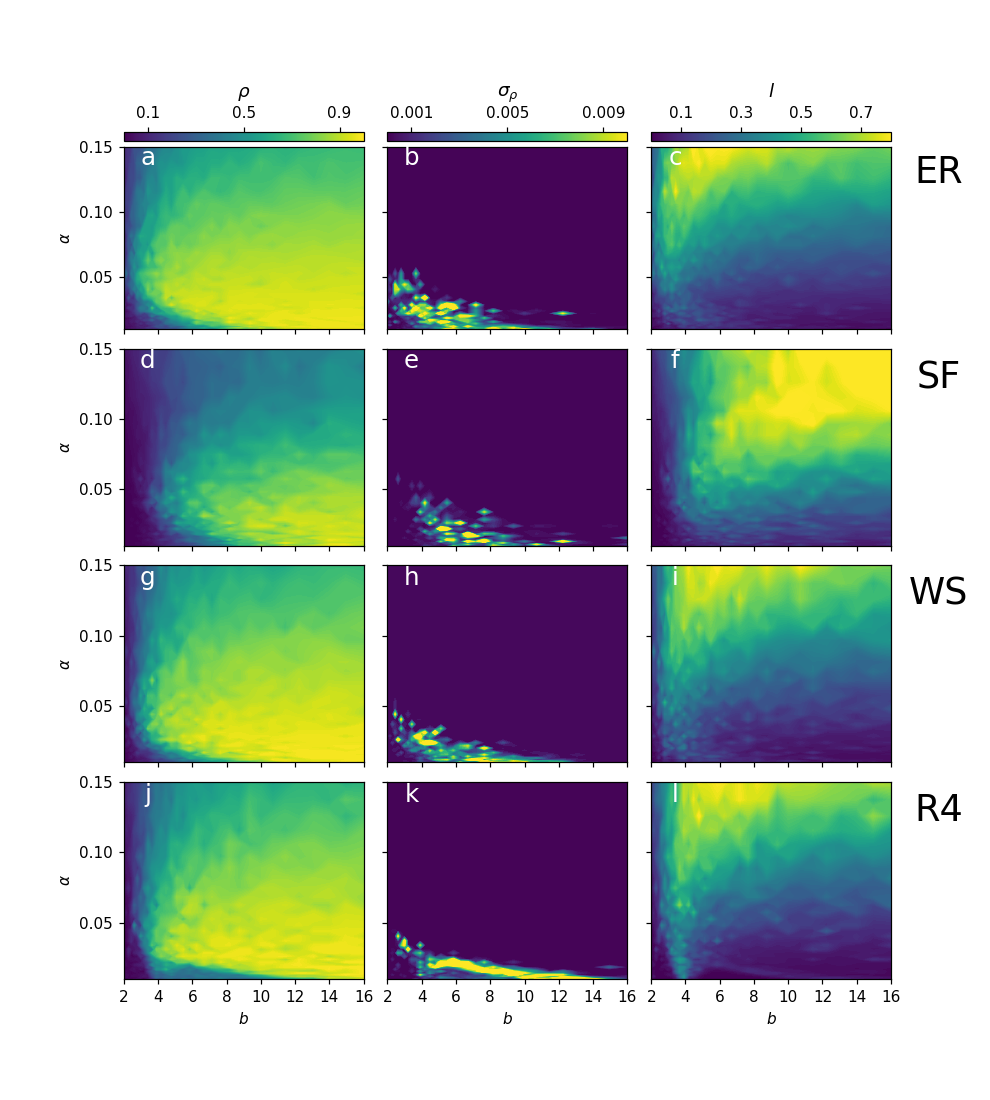

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'label'


In [35]:
plot_2d(alphas, bs, ['sum_er', 'sum_sf', 'sum_ws', 'sum_four'], 100, ['rho', 'stdrho', 'l'], ['ER', 'SF', 'WS', 'R4'])